# Demo
In this notebook a small demonstration of the patch extractor is given. A single WSI from the Bolero dataset was taken for this demo. Download the 'Bolero/RB0004_HE.tiff' and 'Bolero/RB0004_HE.xml' from 'archief' on the AMC server to reproduce.

## Step 1: Converting Whole Slide Images to Biopsies
First we will convert the WSIs to Biopsies from the tiff files using their annotations of the corresponding XML files. 

Structure of the saved dataset is:

- Dataset
    - WSI_name
        - Biopsies
            - biopsy.png
            - exclude.png
            - mask.png
            - (biopsy_mask_exclude_fig.png if save_fig)


<img src='demo_imgs/biopsy_mask_exclude_fig.png'>
---

In [1]:
import os
from wsi2biopsy import WSI2Biopsy

root_dir = 'TIFFs'
out_dir = 'data/demoBarrett20x'
dataset = 'Bolero'
WSI_name = 'RB0004_HE'

magnification = 20
extract_stroma = True

W2B = WSI2Biopsy(root_dir=os.path.join(*[root_dir, dataset]),
                out_dir=os.path.join(*[out_dir, dataset]),
                WSI_name=WSI_name,
                magnification=magnification,
                extract_stroma=extract_stroma,
                verbose=True)

Annotation polygons found for RB0004_HE:
	Special annotations in WSI:
		For Biopsy-Outlines found 5 annotations.
		For E-Stroma found 0 annotations.
		For Exclude found 0 annotations.
	G-level annotations in WSI:
		For NDBE-G found 139 annotations.
		For LGD-G found 12 annotations.
		For HGD-G found 464 annotations.
	T-level annotations in WSI:
		For Squamous-T found 0 annotations.

Extracting biopsy data/demoBarrett20x/Bolero/RB0004_HE/RB0004_HE-1
	Generating biopsy...
	Extracting mask...
		Number of pixels with conflicting labels: 12
	Extracting exclude...

Extracting biopsy data/demoBarrett20x/Bolero/RB0004_HE/RB0004_HE-2
	Generating biopsy...
	Extracting mask...
		Number of pixels with conflicting labels: 61
	Extracting exclude...

Extracting biopsy data/demoBarrett20x/Bolero/RB0004_HE/RB0004_HE-3
	Generating biopsy...
	Extracting mask...
		Number of pixels with conflicting labels: 0
	Extracting exclude...

Extracting biopsy data/demoBarrett20x/Bolero/RB0004_HE/RB0004_HE-4
	Generat

Biopsy: data/demoBarrett20x/Bolero/RB0004_HE/RB0004_HE-1


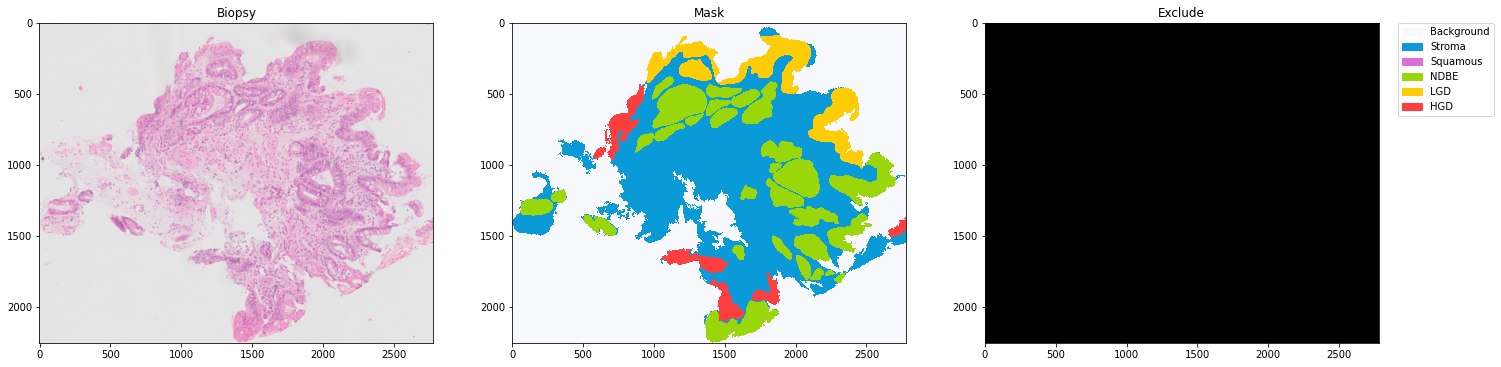

Biopsy: data/demoBarrett20x/Bolero/RB0004_HE/RB0004_HE-2


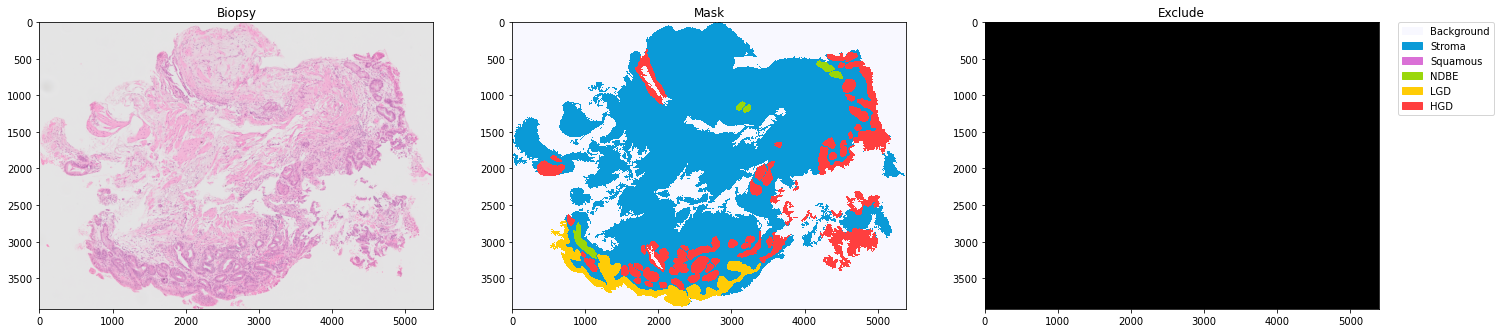

Biopsy: data/demoBarrett20x/Bolero/RB0004_HE/RB0004_HE-3


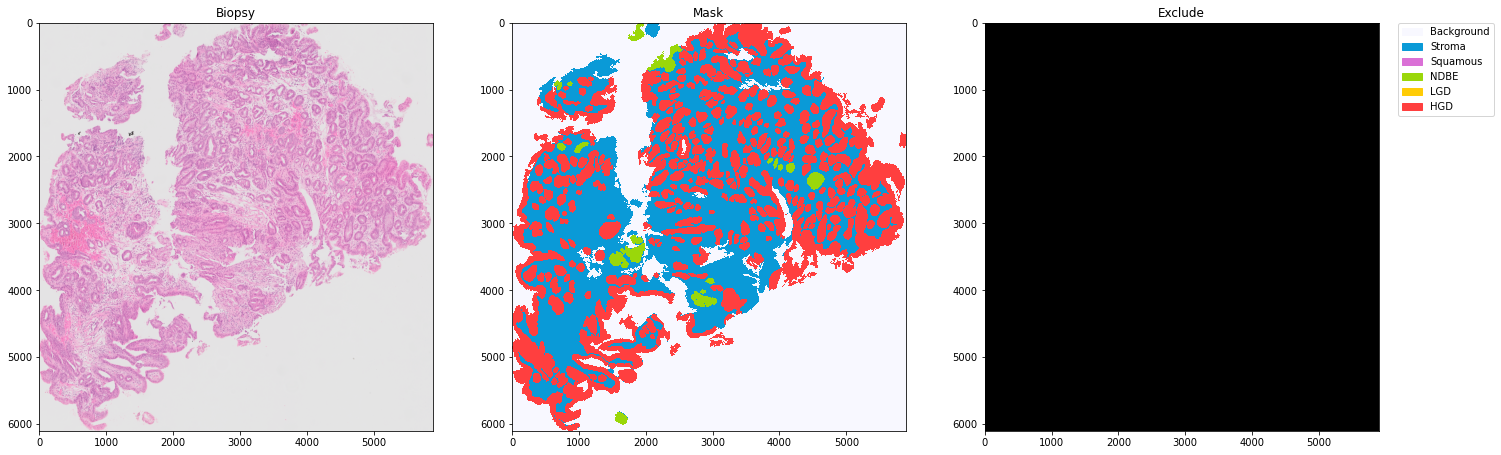

Biopsy: data/demoBarrett20x/Bolero/RB0004_HE/RB0004_HE-4


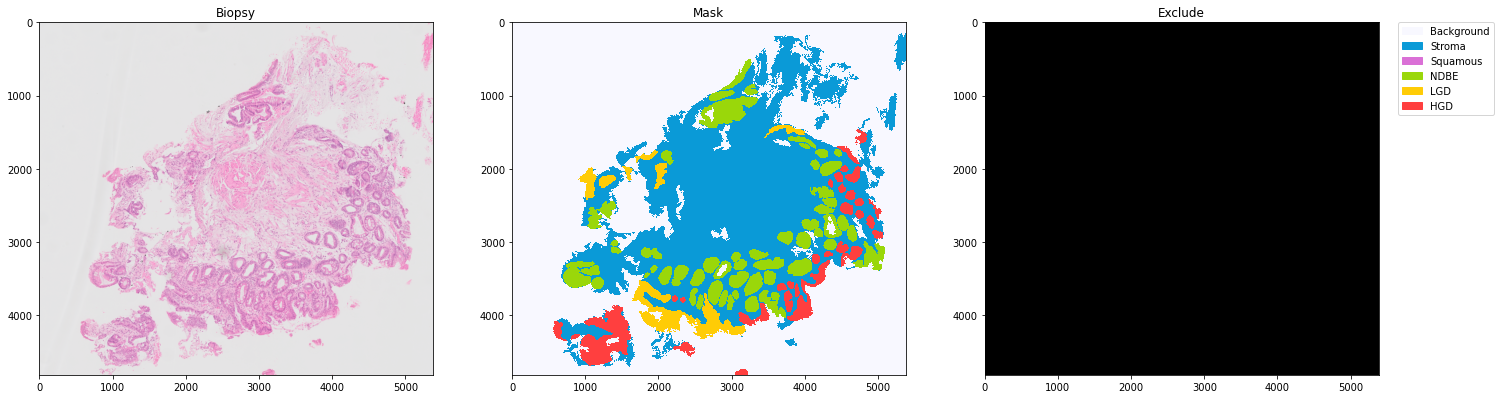

Biopsy: data/demoBarrett20x/Bolero/RB0004_HE/RB0004_HE-5


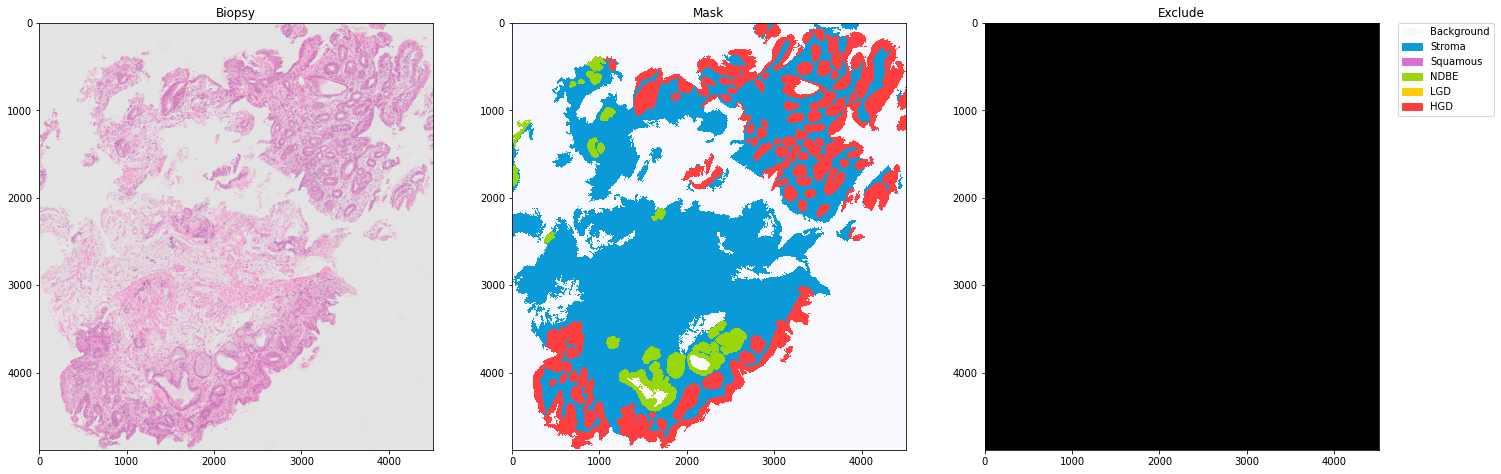

In [2]:
from utils.plotting import plot_biopsy

# Plotting every biopsy.png, mask.png and exclude.png side by side
for biopsy_path in W2B.biopsy_dict.keys():
    print(f"Biopsy: {biopsy_path}")
    plot_biopsy(biopsy_path)

## Step 2: Extracting patches from Biopsies
The second step is to extract the patches. Given a patch size (HxW) and stride (vertical_stride, horizontal_stride), all patches from the biopsy.png and mask.png are generated. If the area of Squamous, NDBE, LGD and HGD is greater than the threshold, the patch is saved. A multiindex dataframe is also created to save relevant labels for patches and entire biopsies.

Below is a gif of the original mask and biopsy with accepted (green) and rejected (red) patches drawn on them next to the extracted patch.

<img src='demo_imgs/patches_from_biopsy.gif'>

<img src='demo_imgs/patches_from_mask.gif'>

In [3]:
from biopsy2patches import Biopsy2Patches
from utils.utils import create_dataframes

out_dir_patches = 'data/demoBarrett20x_patched'
patch_size = (224, 224)
stride = (224, 224)
threshold=0.15

df_biopsy, df_patches = create_dataframes(out_dir, [dataset])

for biopsy in os.listdir(os.path.join(*[out_dir, dataset, WSI_name])):
    save_fig = True if biopsy == 'RB0004_HE-1' else False

    B2P = Biopsy2Patches(root_dir=os.path.join(*[out_dir, dataset, WSI_name, biopsy]),
                    out_dir=os.path.join(*[out_dir_patches, dataset, WSI_name, biopsy]),
                    patch_size=patch_size,
                    stride=stride,
                    threshold=threshold,
                    save_gif=save_fig)

    print(f'\t\tExtracted {max(B2P.label_dict_patches.keys())} patches of the {len(B2P.patches_xy)}')

    df_biopsy.loc[(dataset, WSI_name, biopsy), :] = list(B2P.label_dict_biopsy.values())
    for idx, patch_dict in B2P.label_dict_patches.items():
        df_patches.loc[(dataset, WSI_name, biopsy, idx), :] = list(patch_dict.values())


	Creating gif files...
		For masks...


100%|██████████| 120/120 [00:24<00:00,  4.81it/s]


		For biopsy...


100%|██████████| 120/120 [01:05<00:00,  1.83it/s]


		Extracted 45 patches of the 120
		Extracted 147 patches of the 420
		Extracted 96 patches of the 408
		Extracted 386 patches of the 702
		Extracted 134 patches of the 504


In [6]:
print("Labels on Biopsy level\n", df_biopsy)

Labels on Biopsy level
                                height  width  Background   Stroma  Squamous  \
Dataset WSI_name  Biopsy                                                      
Bolero  RB0004_HE RB0004_HE-1    2256   2780     3593123  1546090         0   
                  RB0004_HE-5    4884   4508    10617761  7665685         0   
                  RB0004_HE-2    3920   5388    10219149  8607113         0   
                  RB0004_HE-3    6104   5892    16626256  9488520         0   
                  RB0004_HE-4    4816   5381    15482064  7104669         0   

                                  NDBE     LGD      HGD  center_label  \
Dataset WSI_name  Biopsy                                                
Bolero  RB0004_HE RB0004_HE-1   700327  277697   154443             1   
                  RB0004_HE-5   613776       0  3119850             1   
                  RB0004_HE-2   111429  525253  1658016             1   
                  RB0004_HE-3   473890       0  9376102  

In [7]:
print("Labels on Patch level\n", df_patches)

Labels on Patch level
                                               x       y  Background   Stroma  \
Dataset WSI_name  Biopsy      Patch_idx                                        
Bolero  RB0004_HE RB0004_HE-1 0          1120.0     0.0     31348.0    687.0   
                  RB0004_HE-5 0          2688.0     0.0     27608.0   3354.0   
                  RB0004_HE-2 0          1568.0   448.0      9927.0  27278.0   
                  RB0004_HE-3 0          1792.0     0.0     22465.0   2436.0   
                  RB0004_HE-4 0          3136.0   448.0     25843.0  10579.0   
...                                         ...     ...         ...      ...   
                              130        2240.0  4256.0     29119.0   3168.0   
                              131        2464.0  4256.0     40698.0     96.0   
                              132         896.0  4480.0      7607.0  11591.0   
                              133        1120.0  4480.0      4701.0   4645.0   
                 